# HandSegNet Demo

This notebook shows how HandSegNet is used.

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
import dilation2d

## Initialization

Create the model and initialize the weights.

In [2]:
handsegnet = HandSegNet()

## Import weights from Tensorflow model

The original HandSegNet was implemented in Tensorflow. The pre-trained model weights need to be imported.

In [3]:
file_name = '/home/ajdillhoff/Downloads/ColorHandPose3D_data_v3/weights/handsegnet-rhd.pickle'
session = tf.Session()
exclude_var_list = list()
# exclude_var_list = ['HandSegNet/conv5_2/weights', 
#                     'HandSegNet/conv5_2/biases', 
#                     'HandSegNet/conv6_1/weights', 
#                     'HandSegNet/conv6_1/biases']

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
for name, module in handsegnet.named_children():
    key = 'HandSegNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        w = w.permute((3, 2, 1, 0))
        module.weight.data = w
        module.bias.data = b

## Test HandSegNet on a sample

Now that the pre-trained weights are loaded, test a sample from RHD.

In [4]:
def visualize_mask(img, mask):
    plt.figure(figsize=(16, 16))
    plt.subplot(121)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

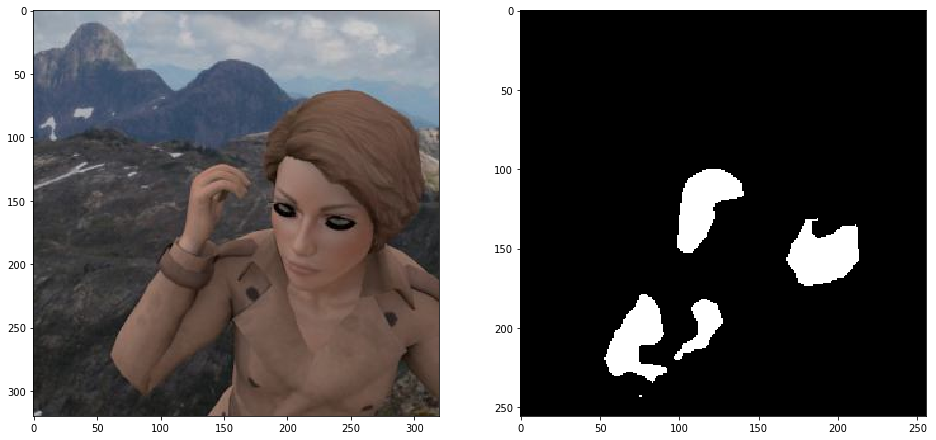

In [56]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/03000.png')
sample = transform1(transform2(img)).unsqueeze(0)
sample -= sample.mean()
output = handsegnet.forward(sample)
mask = output.argmax(1).to(torch.float)
mask_img = transform0(mask.to(torch.float))

visualize_mask(img, mask_img)

## Morphological Dilation

Before we can implement the utility function `single_obj_scoremap` from the Tensorflow implementation, morphological dilation needs to be implemented in PyTorch. There are currently no implementations of this.

In [6]:
def dilation(x, kernel, stride=[1, 1], rates=[1, 1], padding=[0, 0]):
    """Computes the dilation of a 4D input with a 3D kernel.
    
    Args:
        x - (batch_size, channel_size, height, width): Input `Tensor`.
        kernel - (chanel_size, height, width): Dilation kernel.
        stride - (stride_height, stride_width): A list of `int`s determining
            the stride of the `kernel`.
        rates - (rate_height, rate_width): A list of `int`s determining the stride
            for atrous morphological dilation.
        padding - (padding_height, padding_width): A list of `int`s defining the amount
            of padding to add to the input `Tensor`.
            
    Returns:
        A `Tensor` with the same type as `x`.
    """
    # TODO(Alex): Check that the dilation rate and kernel size are appropriate given the input size.
    assert len(x.shape) == 4, "Input must be 4D (N, C, H, W)"
    assert len(kernel.shape) == 3, "Kernel must be 3D (C, H, W)"
    
    # Calculate output height and width
    output_height = math.floor((x.shape[2] + 2 * padding[0] - kernel.shape[1]) / stride[0]) + 1
    output_width = math.floor((x.shape[3] + 2 * padding[1] - kernel.shape[2]) / stride[1]) + 1
    
    output = torch.zeros(x.shape[0], x.shape[1], output_height, output_width)
    
    # C++ implementation
    dilation2d.dilation2d(x, kernel, stride[0], stride[1], rates[0], rates[1], padding[0], padding[1], output)
    
    return output

## Single Object Scoremap

The result of HandSegNet goes through some intermediate processing steps. The first is to find the most likely object in the segmentation map.

In [53]:
def max_coordinate_dense(x):
    """Calculates the x, y coordinates of the maximum value (per channel) in a matrix.
    
    Args:
        x - (batch_size, channel_size, height, width): Input tensor.
    
    Returns:
        A tensor of size (batch_size, channel_size, height, width) where each batch item
        is a zero-matrix per channel except for the location of the largest calculated value.
    """
    
    s = x.shape
    print('max_coordinate_dense(): s: {0}'.format(s))
        
    if len(s) == 3:
        output = torch.zeros_like(x, dtype=torch.int32)
        coords = x.view(s[0], -1)
        _, max_coords = torch.max(coords, -1)
        X = torch.remainder(max_coords[:], s[1])
        Y = max_coords[:] / s[2]
        output[:, Y, X] = 1
        
    return output

def single_obj_scoremap(mask, filter_size=21):
    """Calculates the most likely object given the segmentation score map."""
    
    padding_size = math.floor(filter_size / 2)
    s = mask.shape
    assert len(s) == 4, "Scoremap must be 4D."
    
    scoremap_softmax = F.softmax(mask, dim=1)
    print(scoremap_softmax.shape)
    scoremap_softmax = scoremap_softmax[:, 1, :, :].unsqueeze(0)
    print(scoremap_softmax.shape)
    scoremap_fg_vals, scoremap_fg_idxs = scoremap_softmax.max(dim=1, keepdim=False)
    detmap_fg = torch.round(scoremap_fg_vals)
    print('detmap_fg mean: {0}'.format(detmap_fg.mean()))
    
    max_loc = max_coordinate_dense(scoremap_fg_vals).to(torch.float32)
    
    objectmap_list = []
    kernel_dil = torch.ones(1, filter_size, filter_size) / float(filter_size * filter_size)
        
    for i in range(s[0]):
        # create initial object map
        objectmap = max_loc[i]
        
        num_passes = max(s[2], s[3]) // (filter_size // 2)
        for j in range(num_passes):
            objectmap = torch.reshape(objectmap, [1, 1, s[2], s[3]])
            objectmap_dil = dilation(objectmap, kernel_dil, padding=[padding_size, padding_size])
            objectmap_dil = torch.reshape(objectmap_dil, [s[2], s[3]])
            objectmap = torch.round(detmap_fg[i, :, :] * objectmap_dil)
            
        objectmap = torch.reshape(objectmap, [1, s[2], s[3]])
        objectmap_list.append(objectmap)
            
    return torch.stack(objectmap_list)

In [57]:
print(output.shape)
test_output = single_obj_scoremap(output, 21)
print(test_output.max())

torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 1, 256, 256])
detmap_fg mean: 0.0644073486328125
max_coordinate_dense(): s: torch.Size([1, 256, 256])
tensor(1., grad_fn=<MaxBackward1>)


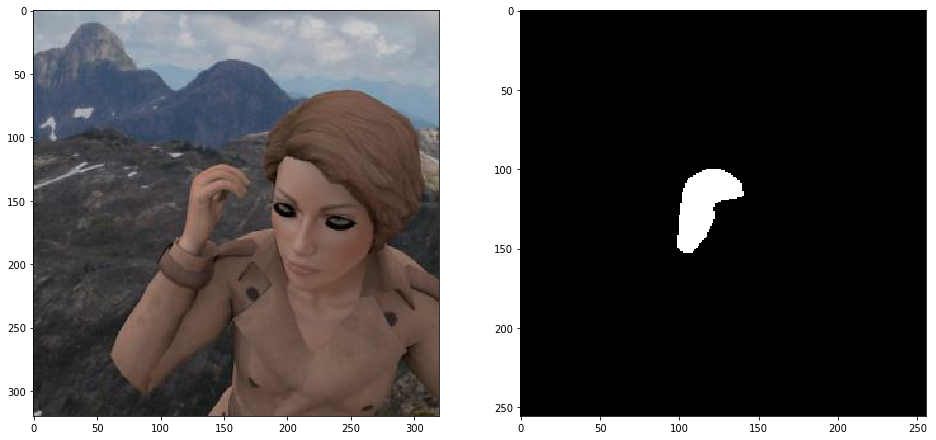

In [58]:
t_img = transform0(test_output[0])

visualize_mask(img, t_img)